In [150]:
import torch.nn as nn
import torch.nn.functional as F

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import utils
import time
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, MSELoss
from torch.nn.utils import parameters_to_vector
from copy import deepcopy
from laplace import Laplace, marglik_training
from laplace.utils import expand_prior_precision
from laplace.curvature import AsdlGGN, BackPackGGN


# Vanilla LeNet

## F-MNIST

In [2]:
import wandb

In [33]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

batch_size = 4

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


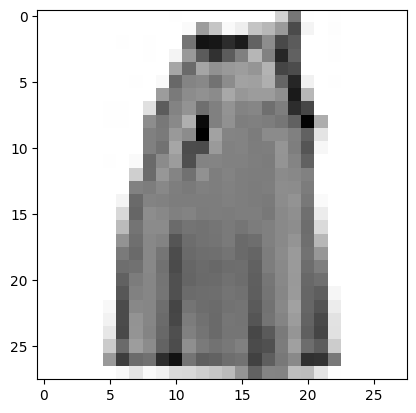

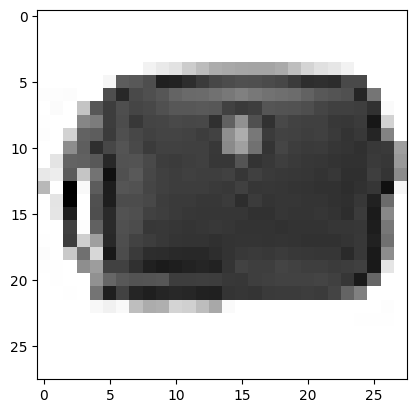

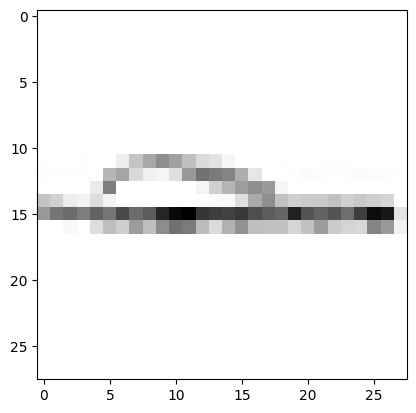

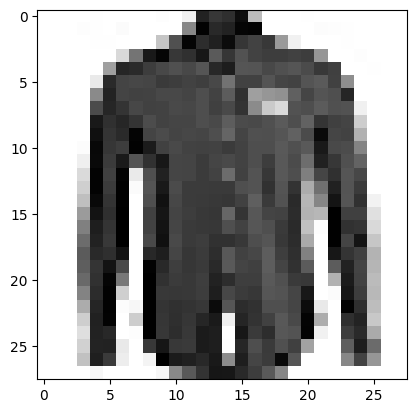

In [36]:
data, labels = next(iter(training_loader))
for im in data:
    plt.imshow(im.reshape(28, 28, 1), cmap="Greys")
    plt.show()

## The model

In [77]:
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [5]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.3892, 0.2359, 0.0560, 0.1290, 0.5504, 0.5160, 0.6563, 0.5478, 0.6901,
         0.7383],
        [0.2647, 0.8819, 0.6576, 0.4501, 0.5980, 0.0604, 0.5582, 0.4023, 0.1027,
         0.3819],
        [0.2415, 0.0287, 0.9485, 0.2707, 0.4830, 0.5920, 0.2904, 0.6095, 0.1930,
         0.7726],
        [0.4844, 0.3272, 0.5835, 0.4474, 0.2003, 0.3271, 0.7186, 0.4221, 0.2059,
         0.1880]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.511805534362793


In [6]:
pred = torch.max(dummy_outputs, dim=1)[0]
pred==dummy_labels

tensor([False, False, False, False])

In [10]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(training_loader):
        optimizer.zero_grad()

        inputs, labels = data
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()
        scheduler.step()


        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
   
            running_loss = 0.

    return last_loss

In [11]:
data = next(iter(validation_loader))
img, labels = data

In [118]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

learning_rate = 0.001
n_steps = EPOCHS*len(training_loader)
lr_min = 1e-6

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_steps, eta_min=lr_min)
best_vloss = 1_000_000.
times = []

run = wandb.init(
    project="Bayesian-ML",
    
    config={
        "model" : "Vanilla",
        "learning_rate": learning_rate,
        "epochs": EPOCHS,
        "min_lr": lr_min,
        "T_max": n_steps
    },
)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    model.train(True)
    t0 = time.time()
    avg_loss = train_one_epoch(epoch_number, writer)
    t1 = time.time()
    times.append(t1-t0)

    running_vloss = 0.0
    model.eval()

    with torch.no_grad():
        correct = torch.Tensor()
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
            voutputs = torch.max(voutputs, dim=1)[1]
            correct = torch.cat((correct, voutputs==vlabels))

        val_acc = torch.sum(correct)/correct.shape[0]

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {} acc {}'.format(avg_loss, avg_vloss, val_acc))
    run.log({"training loss" : avg_loss, "validation loss" : avg_vloss, "validation accuracy" : val_acc})

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'models/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

training loss,█▇▃▂▁
validation accuracy,▁▄▅██
validation loss,█▄▃▁▁
training loss,0.20843
validation accuracy,0.8976
validation loss,0.28006


EPOCH 1:
  batch 1000 loss: 0.27913422818207145
  batch 2000 loss: 0.2809615921917709
  batch 3000 loss: 0.30422109614660847
  batch 4000 loss: 0.29032007284034694
  batch 5000 loss: 0.2922251360228819
  batch 6000 loss: 0.2900869812930112
  batch 7000 loss: 0.30517185029233473
  batch 8000 loss: 0.3000255482314301
  batch 9000 loss: 0.30199957076022726
  batch 10000 loss: 0.30701335945461367
  batch 11000 loss: 0.3023249564481419
  batch 12000 loss: 0.2852728560336553
  batch 13000 loss: 0.3034954785378468
  batch 14000 loss: 0.3011928858544692
  batch 15000 loss: 0.3036567089128315
LOSS train 0.3036567089128315 valid 0.3248206675052643 acc 0.8842999935150146
EPOCH 2:
  batch 1000 loss: 0.26701597488255596
  batch 2000 loss: 0.2675930885577475
  batch 3000 loss: 0.2859625696656501
  batch 4000 loss: 0.28826559546965075
  batch 5000 loss: 0.26777398184939155
  batch 6000 loss: 0.2661565842137918
  batch 7000 loss: 0.25488870940157954
  batch 8000 loss: 0.28731987085504557
  batch 9000 

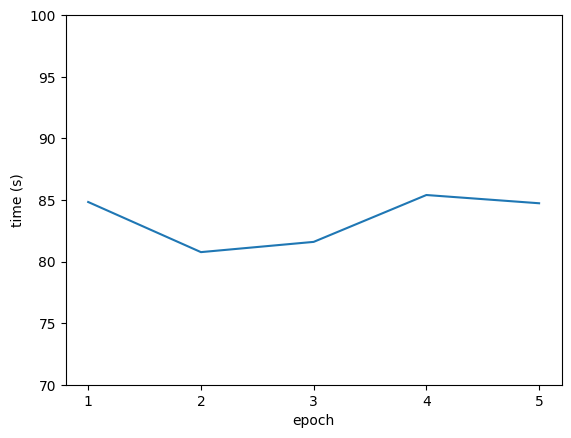

In [125]:
plt.plot(range(1, 6), times)
plt.ylim(70, 100)
plt.xticks(range(1, 6))
plt.xlabel('epoch')
plt.ylabel('time (s)')
plt.show()

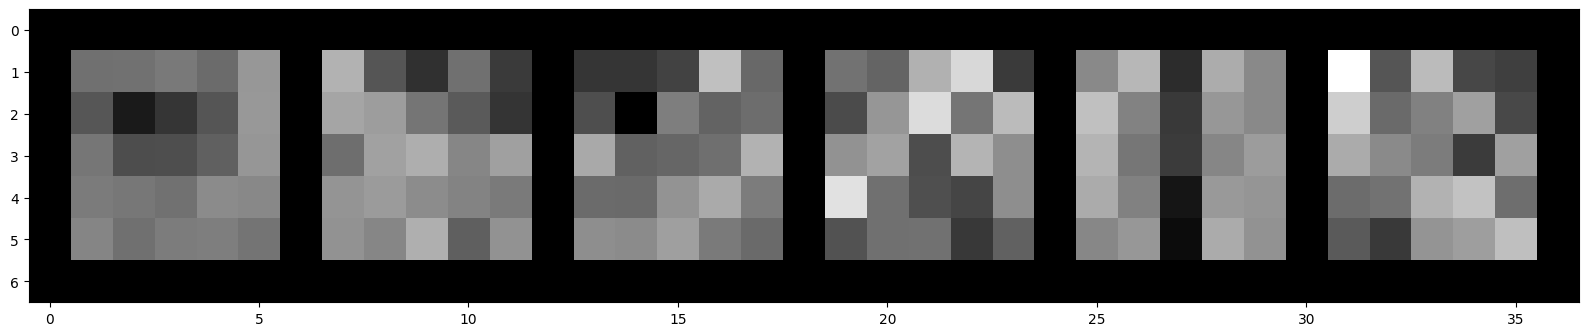

In [126]:
filters = (model.conv1.weight.clone())#+model.conv1.bias[:, None, None, None]).clone()
out_c, in_c, h, w = filters.shape
filters = filters.view(out_c*in_c, -1, h, w)
n_col = 16
rows = np.min((filters.shape[0] // n_col+1, 32))
grid = utils.make_grid(filters, nrow=n_col, normalize=True, padding=1)
plt.figure(figsize=(20, 20))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()

# Bayesian CNN

In [146]:
# from laplace import KronLaplace, DiagLLLaplace, KronLLLaplace, FullLLLaplace, marglik_training
# from laplace.curvature import AsdlGGN, BackPackGGN
# from laplace.utils import expand_prior_precision, fix_prior_prec_structure

In [17]:
run = wandb.init(
    
    project="Bayesian-ML",
    
    config={
        "learning_rate": learning_rate,
        "epochs": EPOCHS,
        "min_lr": lr_min,
        "T_max": n_steps
    },
)
model_bayes = GarmentClassifier()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5*5000, eta_min=1e-6)


la, model_bayes, margliks, losses = marglik_training(
    model=model, train_loader=training_loader, likelihood='classification',
    hessian_structure='kron', backend=AsdlGGN, n_epochs=EPOCHS, 
    optimizer_kwargs={'lr': learning_rate}, scheduler_cls=torch.optim.lr_scheduler.CosineAnnealingLR, scheduler_kwargs={"T_max": n_steps, "eta_min": lr_min}, n_hypersteps=100, marglik_frequency=1, prior_structure='layerwise'
)

### Bayesian loop

we take the original marginal likelihood training loop and compare the performance with training a vanilla LeNet

In [151]:
def marglik_training_test(
    model,
    train_loader,
    likelihood='classification',
    hessian_structure='kron',
    backend=AsdlGGN,
    optimizer_cls=Adam,
    optimizer_kwargs=None,
    scheduler_cls=None,
    scheduler_kwargs=None,
    n_epochs=300,
    lr_hyp=1e-1,
    prior_structure='layerwise',
    n_epochs_burnin=0,
    n_hypersteps=10,
    marglik_frequency=1,
    prior_prec_init=1.,
    sigma_noise_init=1.,
    temperature=1.
):  
    # if 'weight_decay' in optimizer_kwargs:
    #     warnings.warn('Weight decay is handled and optimized. Will be set to 0.')
    #     optimizer_kwargs['weight_decay'] = 0.0

    # get device, data set size N, number of layers H, number of parameters P
    device = parameters_to_vector(model.parameters()).device
    N = len(train_loader.dataset)
    H = len(list(model.parameters()))
    P = len(parameters_to_vector(model.parameters()))

    times_nn = []
    times_laplace = []

    # differentiable hyperparameters
    hyperparameters = list()
    # prior precision
    log_prior_prec_init = np.log(temperature * prior_prec_init)
    if prior_structure == 'scalar':
        log_prior_prec = log_prior_prec_init * torch.ones(1, device=device)
    elif prior_structure == 'layerwise':
        log_prior_prec = log_prior_prec_init * torch.ones(H, device=device)
    elif prior_structure == 'diagonal':
        log_prior_prec = log_prior_prec_init * torch.ones(P, device=device)
    else:
        raise ValueError(f'Invalid prior structure {prior_structure}')
    log_prior_prec.requires_grad = True
    hyperparameters.append(log_prior_prec)

    # set up loss (and observation noise hyperparam)
    if likelihood == 'classification':
        criterion = CrossEntropyLoss(reduction='mean')
        sigma_noise = 1.
    elif likelihood == 'regression':
        criterion = MSELoss(reduction='mean')
        log_sigma_noise_init = np.log(sigma_noise_init)
        log_sigma_noise = log_sigma_noise_init * torch.ones(1, device=device)
        log_sigma_noise.requires_grad = True
        hyperparameters.append(log_sigma_noise)

    # set up model optimizer
    if optimizer_kwargs is None:
        optimizer_kwargs = dict()
    optimizer = optimizer_cls(model.parameters(), **optimizer_kwargs)

    # set up learning rate scheduler
    if scheduler_cls is not None:
        if scheduler_kwargs is None:
            scheduler_kwargs = dict()
        scheduler = scheduler_cls(optimizer, **scheduler_kwargs)

    # set up hyperparameter optimizer
    hyper_optimizer = Adam(hyperparameters, lr=lr_hyp)

    best_marglik = np.inf
    best_model_dict = None
    best_precision = None
    losses = list()
    margliks = list()

    for epoch in range(1, n_epochs + 1):
        print(f"epoch {epoch}")
        epoch_loss = 0
        epoch_perf = 0
        
        # standard NN training per batch
        t0 = time.time()
        for i, data in enumerate(train_loader):
            X, y = data
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            if likelihood == 'regression':
                sigma_noise = torch.exp(log_sigma_noise).detach()
                crit_factor = temperature / (2 * sigma_noise.square())
            else:
                crit_factor = temperature
            prior_prec = torch.exp(log_prior_prec).detach()
            theta = parameters_to_vector(model.parameters())
            delta = expand_prior_precision(prior_prec, model)
            f = model(X)
            loss = criterion(f, y) + (0.5 * (delta * theta) @ theta) / N / crit_factor
            loss.backward()
            optimizer.step()
            epoch_loss += loss.cpu().item() #* len(y)
            if likelihood == 'regression':
                epoch_perf += (f.detach() - y).square().sum()
            else:
                epoch_perf += torch.sum(torch.argmax(f.detach(), dim=-1) == y).item()
            if scheduler_cls is not None:
                scheduler.step()
            if i % 1000 == 999:
                last_loss = epoch_loss / 1000 # loss per batch
                print('  batch {} loss: {}'.format(i + 1, last_loss))
        t1 = time.time()
        times_nn.append(t1-t0)
        print(t1-t0)
        losses.append(epoch_loss / N)

        # compute validation error to report during training
        print(f'MARGLIK[epoch={epoch}]: network training. Loss={losses[-1]:.3f}.' +
                     f'Perf={epoch_perf/N:.3f}')

        # only update hyperparameters every marglik_frequency steps after burnin
        if (epoch % marglik_frequency) != 0 or epoch < n_epochs_burnin:
            continue

        # optimizer hyperparameters by differentiating marglik
        # 1. fit laplace approximation
        sigma_noise = 1 if likelihood == 'classification' else torch.exp(log_sigma_noise)
        prior_prec = torch.exp(log_prior_prec)
        lap = Laplace(
            model, likelihood, hessian_structure=hessian_structure, sigma_noise=sigma_noise, 
            prior_precision=prior_prec, temperature=temperature, backend=backend,
            subset_of_weights='all'
        )
        lap.fit(train_loader)

        # 2. differentiate wrt. hyperparameters for n_hypersteps
        for _ in range(n_hypersteps):
            hyper_optimizer.zero_grad()
            if likelihood == 'classification':
                sigma_noise = None
            elif likelihood == 'regression':
                sigma_noise = torch.exp(log_sigma_noise)
            prior_prec = torch.exp(log_prior_prec)
            marglik = -lap.log_marginal_likelihood(prior_prec, sigma_noise)
            marglik.backward()
            hyper_optimizer.step()
            margliks.append(marglik.item())

        # early stopping on marginal likelihood
        if margliks[-1] < best_marglik:
            best_model_dict = deepcopy(model.state_dict())
            best_precision = deepcopy(prior_prec.detach())
            best_sigma = 1 if likelihood == 'classification' else deepcopy(sigma_noise.detach())
            best_marglik = margliks[-1]
            print(f'MARGLIK[epoch={epoch}]: marglik optimization. MargLik={best_marglik:.2f}. '
                         + 'Saving new best model.')
        else:
            print(f'MARGLIK[epoch={epoch}]: marglik optimization. MargLik={margliks[-1]:.2f}.'
                         + f'No improvement over {best_marglik:.2f}')

    print('MARGLIK: finished training. Recover best model and fit Laplace.')
    if best_model_dict is not None:
        model.load_state_dict(best_model_dict)
        sigma_noise = best_sigma
        prior_prec = best_precision
    lap = Laplace(
        model, likelihood, hessian_structure=hessian_structure, sigma_noise=sigma_noise, 
        prior_precision=prior_prec, temperature=temperature, backend=backend,
        subset_of_weights='all'
    )
    lap.fit(train_loader)
    return lap, model, margliks, losses, times_nn, times_laplace


In [153]:
# run = wandb.init(
    
#     project="Bayesian-ML",
    
#     config={
#         "model" : "Laplace",
#         "learning_rate": learning_rate,
#         "epochs": EPOCHS,
#         "min_lr": lr_min,
#         "T_max": n_steps
#     },
# )

model_bayes = GarmentClassifier()

optimizer = torch.optim.Adam(model_bayes.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_steps, eta_min=lr_min)


la, model_bayes, margliks, losses, _, _ = marglik_training_test(
    model=model_bayes, train_loader=training_loader, likelihood='classification',
    hessian_structure='kron', backend=AsdlGGN, n_epochs=EPOCHS, 
    optimizer_kwargs={'lr': learning_rate}, scheduler_cls=torch.optim.lr_scheduler.CosineAnnealingLR, scheduler_kwargs={"T_max": n_steps, "eta_min": lr_min}, n_hypersteps=100, marglik_frequency=1, prior_structure='layerwise'
)

epoch 1
  batch 1000 loss: 0.9825701088793576
  batch 2000 loss: 1.6648744237991049
  batch 3000 loss: 2.269504202162847
  batch 4000 loss: 2.8084771867338567
  batch 5000 loss: 3.309328978673322
  batch 6000 loss: 3.7931255225420464
  batch 7000 loss: 4.256261894239579
  batch 8000 loss: 4.7136244000156875
  batch 9000 loss: 5.15312192843738
  batch 10000 loss: 5.579488011692418
  batch 11000 loss: 5.984878431217279
  batch 12000 loss: 6.362179090596968
  batch 13000 loss: 6.748315291608218
  batch 14000 loss: 7.140159320090665
  batch 15000 loss: 7.505133401401341
101.08067059516907
MARGLIK[epoch=1]: network training. Loss=0.125.Perf=0.814
MARGLIK[epoch=1]: marglik optimization. MargLik=31841.51. Saving new best model.
epoch 2
  batch 1000 loss: 0.39899181517586113
  batch 2000 loss: 0.8184093527905643
  batch 3000 loss: 1.2279017659537494
  batch 4000 loss: 1.6365680576115846
  batch 5000 loss: 2.029194791484624
  batch 6000 loss: 2.4333572336807845
  batch 7000 loss: 2.829328724324

KeyboardInterrupt: 

In [60]:
model.conv2.weight.shape

torch.Size([16, 6, 5, 5])

6
2


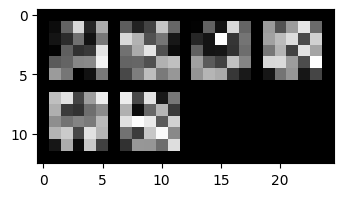

In [81]:
filters = model.conv1.weight.clone()
out_c, in_c, h, w = filters.shape
filters = filters.view(out_c*in_c, -1, h, w)
n_row = 4
print(filters.shape[0])
rows = np.min((filters.shape[0] // n_row+1, 32))
grid = utils.make_grid(filters, nrow=n_row, normalize=True, padding=1)
plt.figure(figsize=(n_row, rows))
print(rows)
plt.imshow(grid.numpy().transpose((1, 2, 0)))